In [1]:
from attomics import *
from json_tools import *
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
# Device
device= torch.device("cuda:1")

Batch_size = 512
n_group = 1000
Feature_total=50000
group_size=int(Feature_total/n_group)

K = torch.rand(Batch_size, n_group, group_size).to(device)
Q = torch.rand(Batch_size, n_group, group_size).to(device)
V = torch.rand(Batch_size, n_group, group_size).to(device)

In [5]:
Q.stride(-1)

1

0
1
2
3
4
5
6
7
8
9
10
11


STAGE:2024-04-11 15:08:14 1496984:1496984 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 15:08:14 1496984:1496984 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 15:08:14 1496984:1496984 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


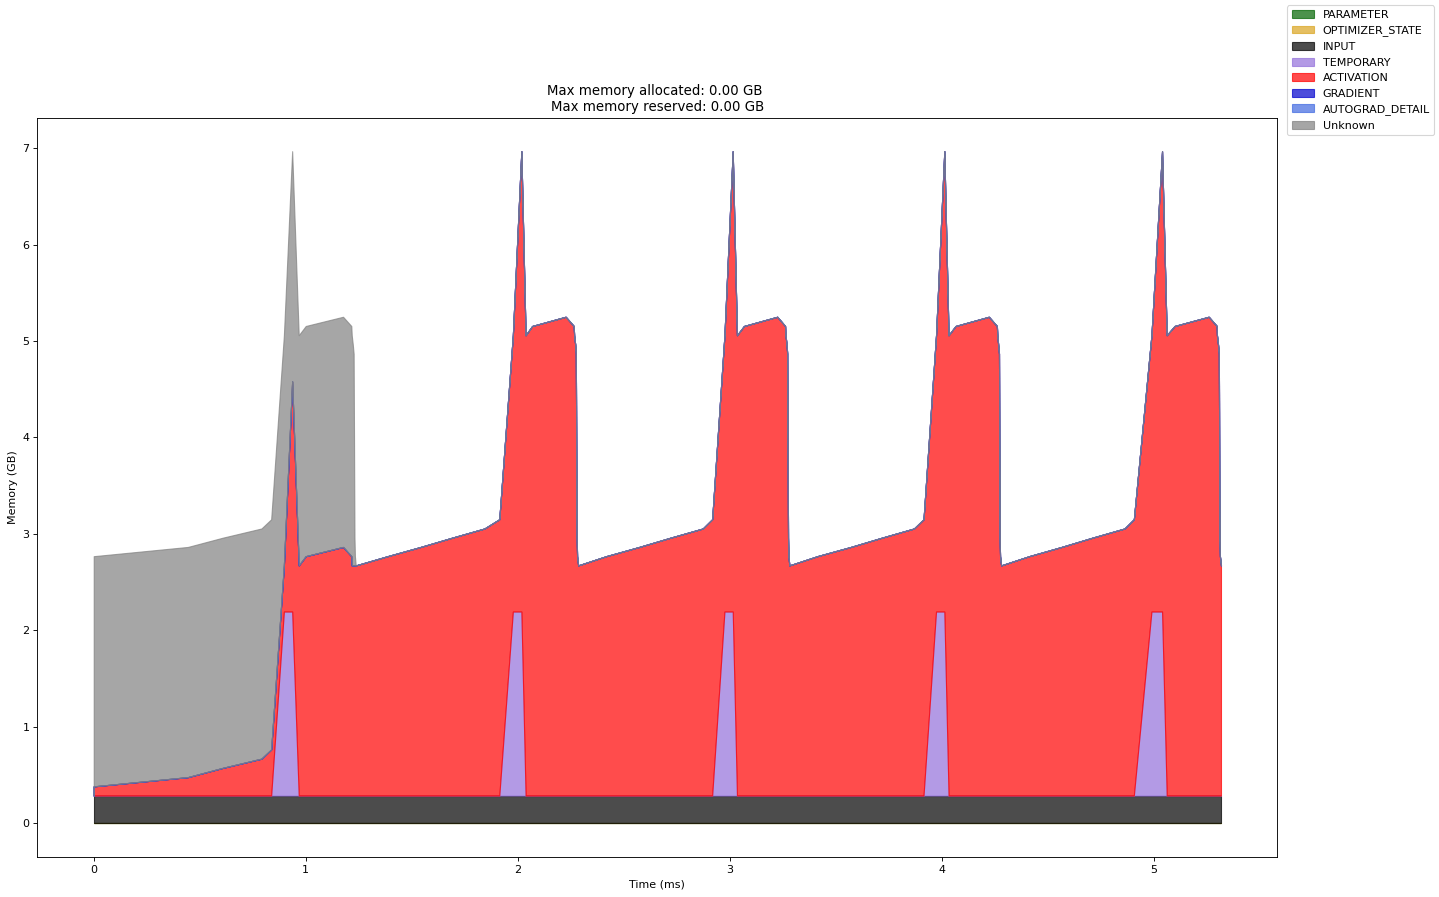

In [15]:
modelname="Attention"

model = MultiHeadAttentionWrapper(group_size, 1, mem_efficient=False)
model = model.to(device)

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True, 
    record_shapes=True,
    with_stack=True,
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=7,
        active=5),
    on_trace_ready=trace_handler
) as p:
    for idx in range(12):
        #print(idx)
        p.step()
        print(idx)
        pred = model(Q, K, V)

del model
torch.cuda.empty_cache()

0
1
2
3
4
5
6
7
8
9
10


STAGE:2024-04-11 15:08:16 1496984:1496984 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 15:08:16 1496984:1496984 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 15:08:16 1496984:1496984 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


11


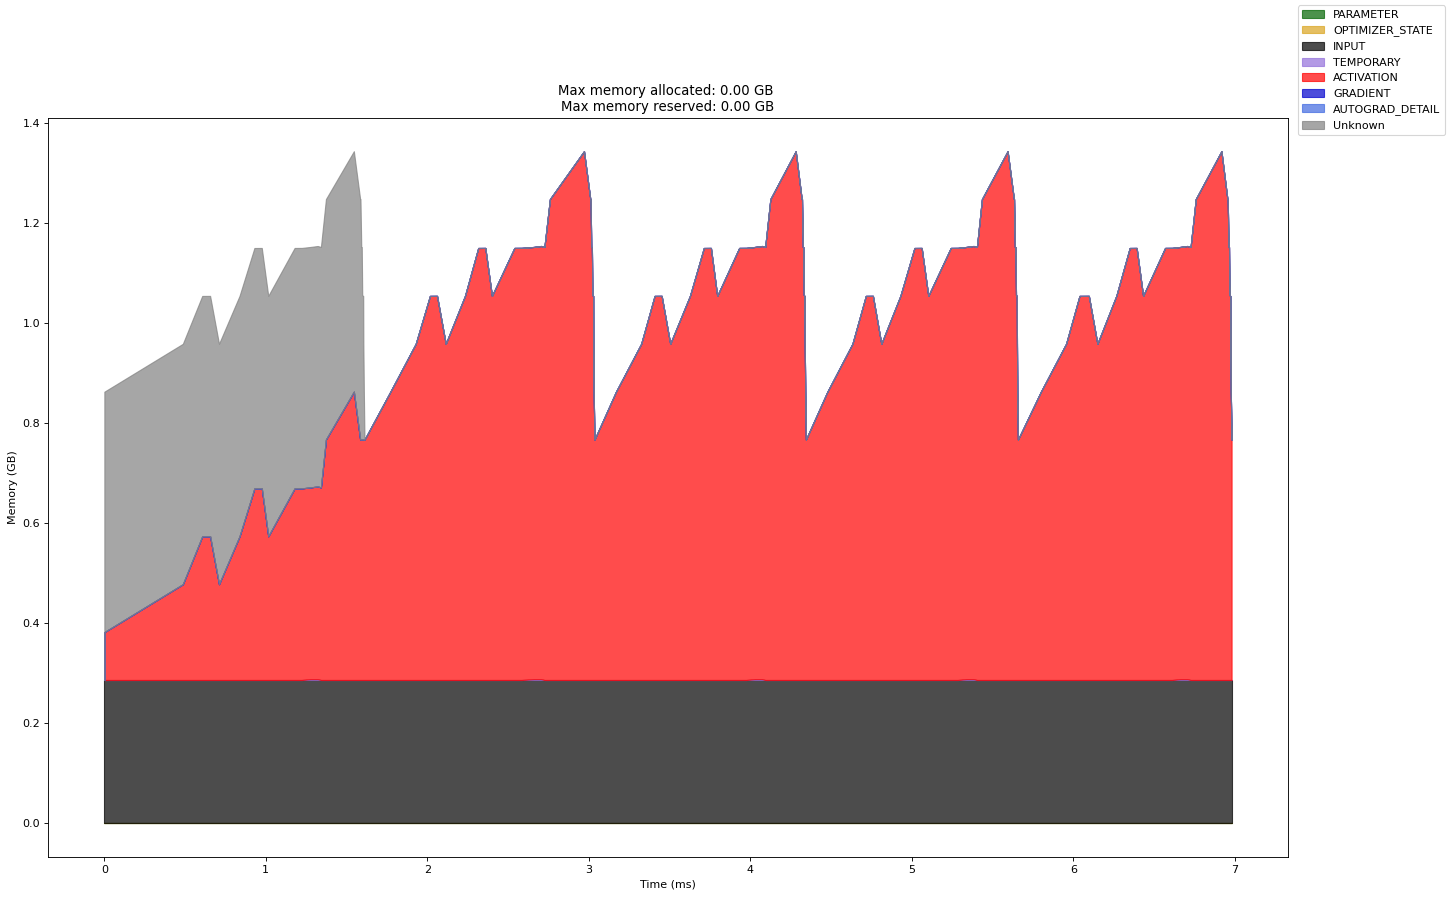

In [16]:
modelname="LinAttention"

model = MultiHeadLinformerWrapper(group_size, 1, n_group, 1, mem_efficient=False)
model = model.to(device)

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True, 
    record_shapes=True,
    with_stack=True,
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=6,
        active=5),
    on_trace_ready=trace_handler
) as p:
    for idx in range(12):
        #print(idx)
        p.step()
        print(idx)
        pred = model(Q, K, V)

del model
torch.cuda.empty_cache()

#(Time_Recorder, Memory_Recorder)= record_time_memory(modelname,Time_Recorder,Memory_Recorder)

In [7]:
modelname="MLP"

model = mRNAMultiClassClassifier(feature_numbers, 1024, 256, len(unique))
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True, 
    record_shapes=True,
    with_stack=True,
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=6,
        active=1),
    on_trace_ready=trace_handler
) as p:
    for idx in range(8):
        #print(idx)
        p.step()
        pred = model(inputs)
        loss_function_weight(pred, labels).backward()
        optimizer.step()
        optimizer.zero_grad()

del model
torch.cuda.empty_cache()

(Time_Recorder, Memory_Recorder)= record_time_memory(modelname,Time_Recorder,Memory_Recorder)

NameError: name 'feature_numbers' is not defined

In [8]:
# Device
device= torch.device("cuda:1")

# Import data
df_mRNA = pd.read_parquet("data_attomics/mRNA.parquet")
df_label = pd.read_parquet("data_attomics/label.parquet")

# Pick multi-classes data
y_tumour = df_label.iloc[:, [0, 2]]

# Pick X_train
scaler=StandardScaler()
X_orignal = df_mRNA.iloc[:,1:df_mRNA.shape[1]]
X_scaled = scaler.fit_transform(X_orignal)

# Pick y_train
y_labels = set(y_tumour['cancer_type'])
y_dic = {label: index for index, label in enumerate(sorted(y_labels))}
y_numerical = np.array([y_dic[label] for label in y_tumour['cancer_type']])

X_train,X_testval,y_train,y_testval=train_test_split(X_scaled, y_numerical, 
                                                         test_size=0.3,random_state=2, stratify=y_numerical)

# Create weight loss function
unique, counts = np.unique(y_numerical, return_counts=True)
total_count = sum(counts)
weights = torch.tensor([total_count / c for c in counts], dtype=torch.float32).to(device)
loss_function_weight = nn.CrossEntropyLoss(weight=weights)

_,X_train_array,_,y_train_array=train_test_split(X_train, y_train, test_size=512, random_state=2, stratify=y_train)

X_train_tensor= torch.tensor(X_train_array)

unique,_ = np.unique(y_train, return_counts=True)
y_train_tensor = torch.tensor(y_train_array)

learning_rate = 0.0001

num_classes = len(unique)
feature_numbers = X_train_tensor.size(1)

Memory_Recorder = pd.DataFrame(columns=['model_name', 'type', 'max_memory_allocated'])
Time_Recorder = pd.DataFrame(columns=['model_name', 'type', 'total_time'])

# Move to GPU, initial optimizer
inputs= X_train_tensor.to(device=device)
labels = y_train_tensor.to(device=device)

STAGE:2024-04-11 13:24:51 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:24:51 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:24:51 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


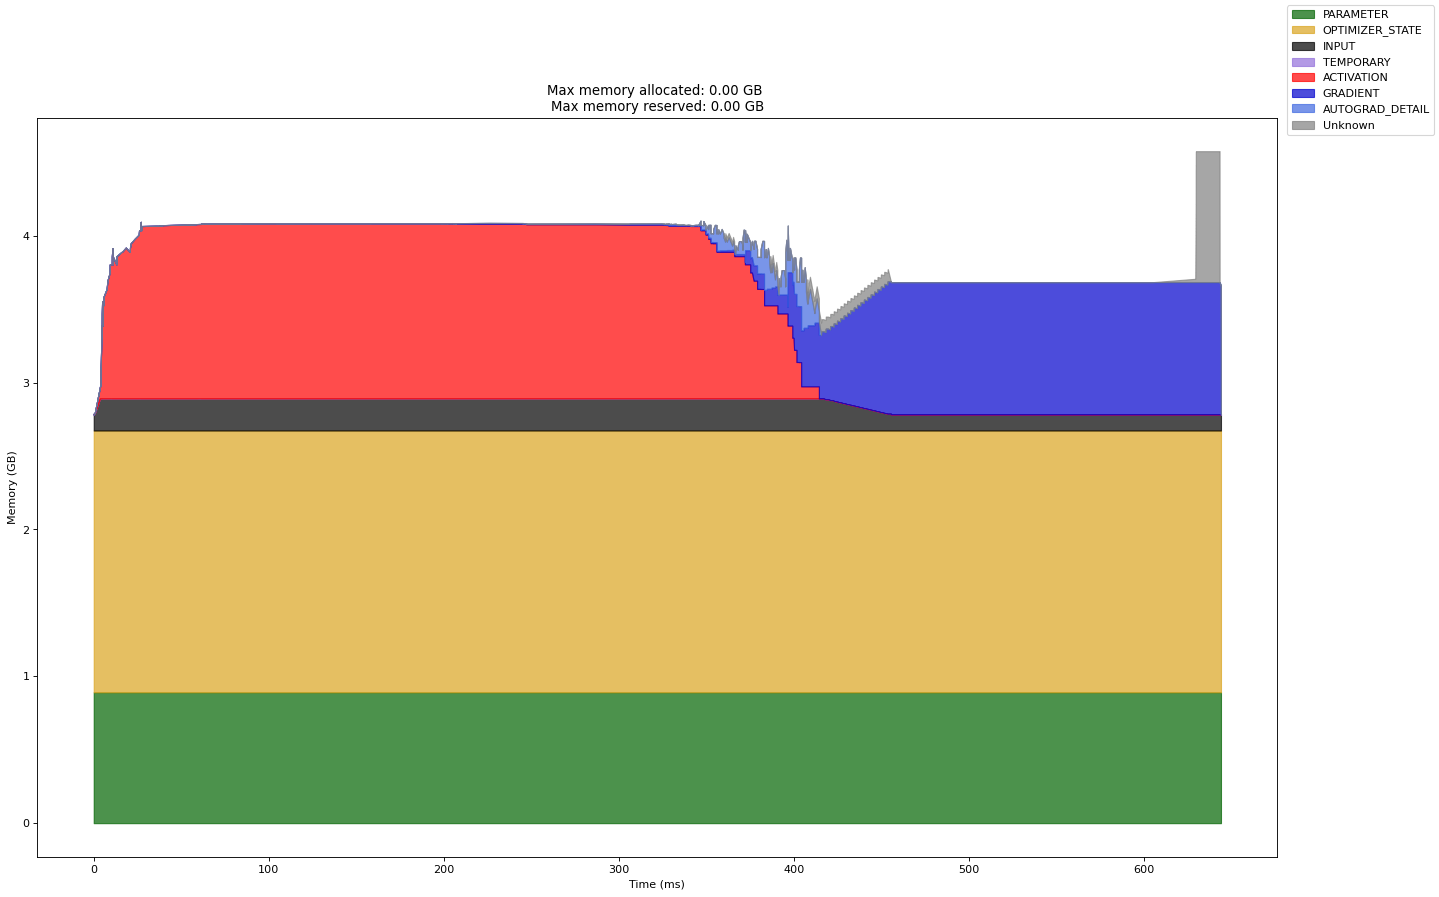

In [9]:
modelname="Attomics"

n_group = 20

encoder = AttOmicsEncoder(
    in_features=feature_numbers, n_group=n_group, group_size_list=[2164, 1459, 754, 50],
    num_heads=1, flatten_output=True, pe=False, permutation=False, permu_inverse=False, mem_efficient = False,
)

head = FullyConnectedNetwork(
    [FullyConnectedLayer(input_dim=n_group*50, output_dim=n_group*25), 
    FullyConnectedLayer(input_dim=n_group*25, output_dim=n_group*10),]
)

model = AttOmics(encoder=encoder, head=head, num_classes=num_classes)

optimizer=optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True, 
    record_shapes=True,
    with_stack=True,
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=6,
        active=1),
    on_trace_ready=trace_handler
) as p:
    for idx in range(8):
        #print(idx)
        p.step()
        pred = model(inputs)
        loss_function_weight(pred, labels).backward()
        optimizer.step()
        optimizer.zero_grad()

del model
torch.cuda.empty_cache()

(Time_Recorder, Memory_Recorder)= record_time_memory(modelname,Time_Recorder,Memory_Recorder)

STAGE:2024-04-11 13:25:00 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:25:01 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:25:01 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


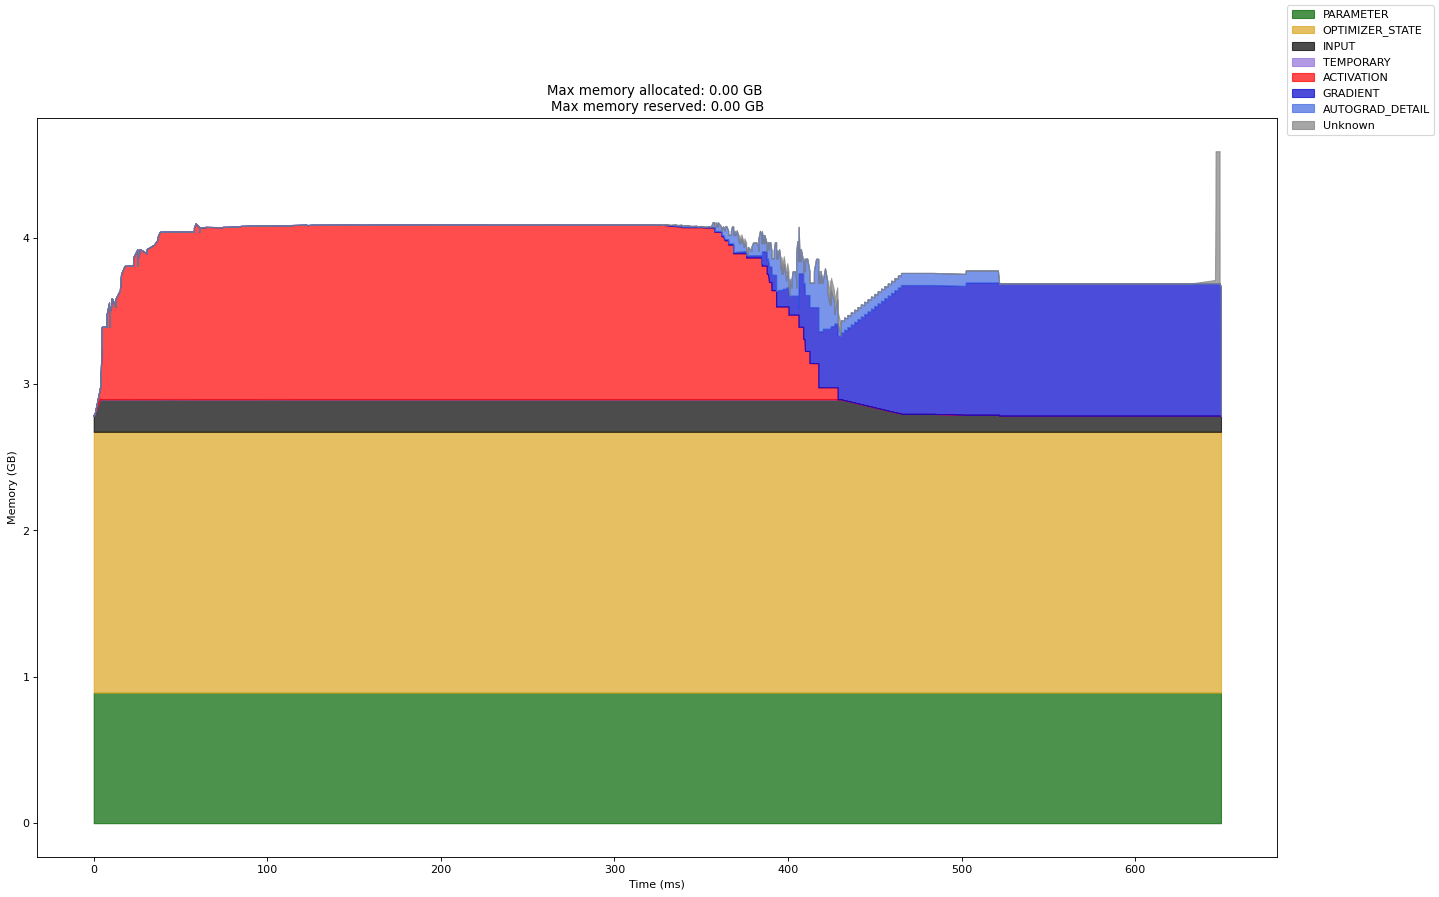

In [10]:
modelname="Attomics_PE"
n_group = 20
encoder = AttOmicsEncoder(
    in_features=feature_numbers, n_group=n_group, group_size_list=[2164, 1459, 754, 50],
    num_heads=1, flatten_output=True, pe=True, permutation=False, permu_inverse=False, mem_efficient = False,
)

head = FullyConnectedNetwork(
    [FullyConnectedLayer(input_dim=n_group*50, output_dim=n_group*25), 
    FullyConnectedLayer(input_dim=n_group*25, output_dim=n_group*10),]
)

model = AttOmics(encoder=encoder, head=head, num_classes=num_classes)

optimizer=optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True, 
    record_shapes=True,
    with_stack=True,
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=6,
        active=1),
    on_trace_ready=trace_handler
) as p:
    for idx in range(8):
        #print(idx)
        p.step()
        pred = model(inputs)
        loss_function_weight(pred, labels).backward()
        optimizer.step()
        optimizer.zero_grad()

del model
torch.cuda.empty_cache()

(Time_Recorder, Memory_Recorder)= record_time_memory(modelname,Time_Recorder,Memory_Recorder)

STAGE:2024-04-11 13:25:09 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:25:10 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:25:10 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


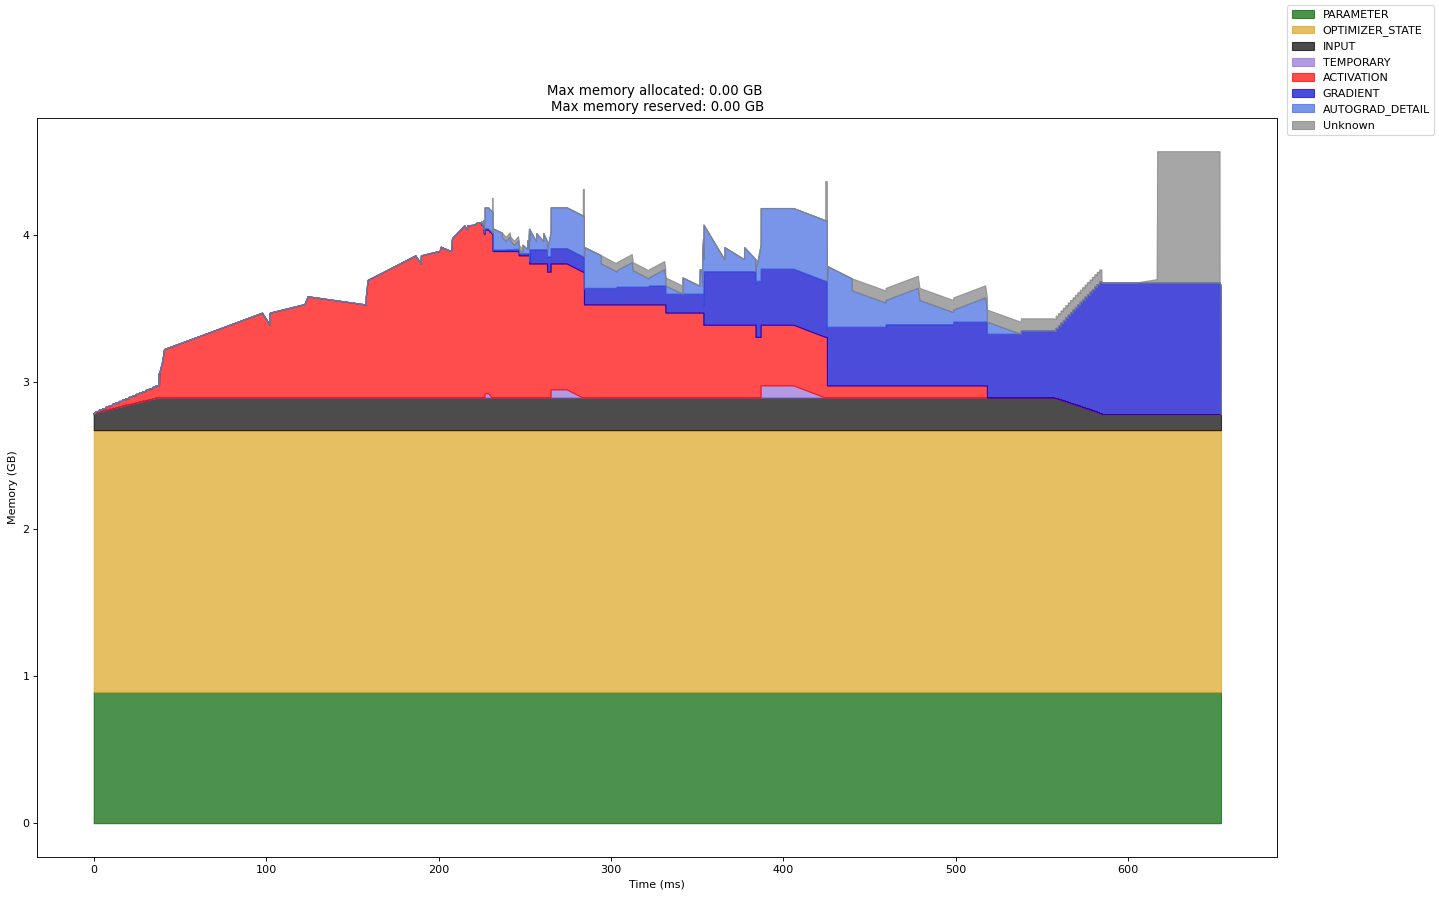

In [11]:
modelname="Attomics_mem_efficient"
n_group = 20
encoder = AttOmicsEncoder(
    in_features=feature_numbers, n_group=n_group, group_size_list=[2164, 1459, 754, 50],
    num_heads=1, flatten_output=True, pe=False, permutation=False, permu_inverse=False, mem_efficient = True,
)

head = FullyConnectedNetwork(
    [FullyConnectedLayer(input_dim=n_group*50, output_dim=n_group*25), 
    FullyConnectedLayer(input_dim=n_group*25, output_dim=n_group*10),]
)

model = AttOmics(encoder=encoder, head=head, num_classes=num_classes)

optimizer=optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True, 
    record_shapes=True,
    with_stack=True,
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=6,
        active=1),
    on_trace_ready=trace_handler
) as p:
    for idx in range(8):
        #print(idx)
        p.step()
        pred = model(inputs)
        loss_function_weight(pred, labels).backward()
        optimizer.step()
        optimizer.zero_grad()

del model
torch.cuda.empty_cache()

(Time_Recorder, Memory_Recorder)= record_time_memory(modelname,Time_Recorder,Memory_Recorder)

STAGE:2024-04-11 13:25:18 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:25:19 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:25:19 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


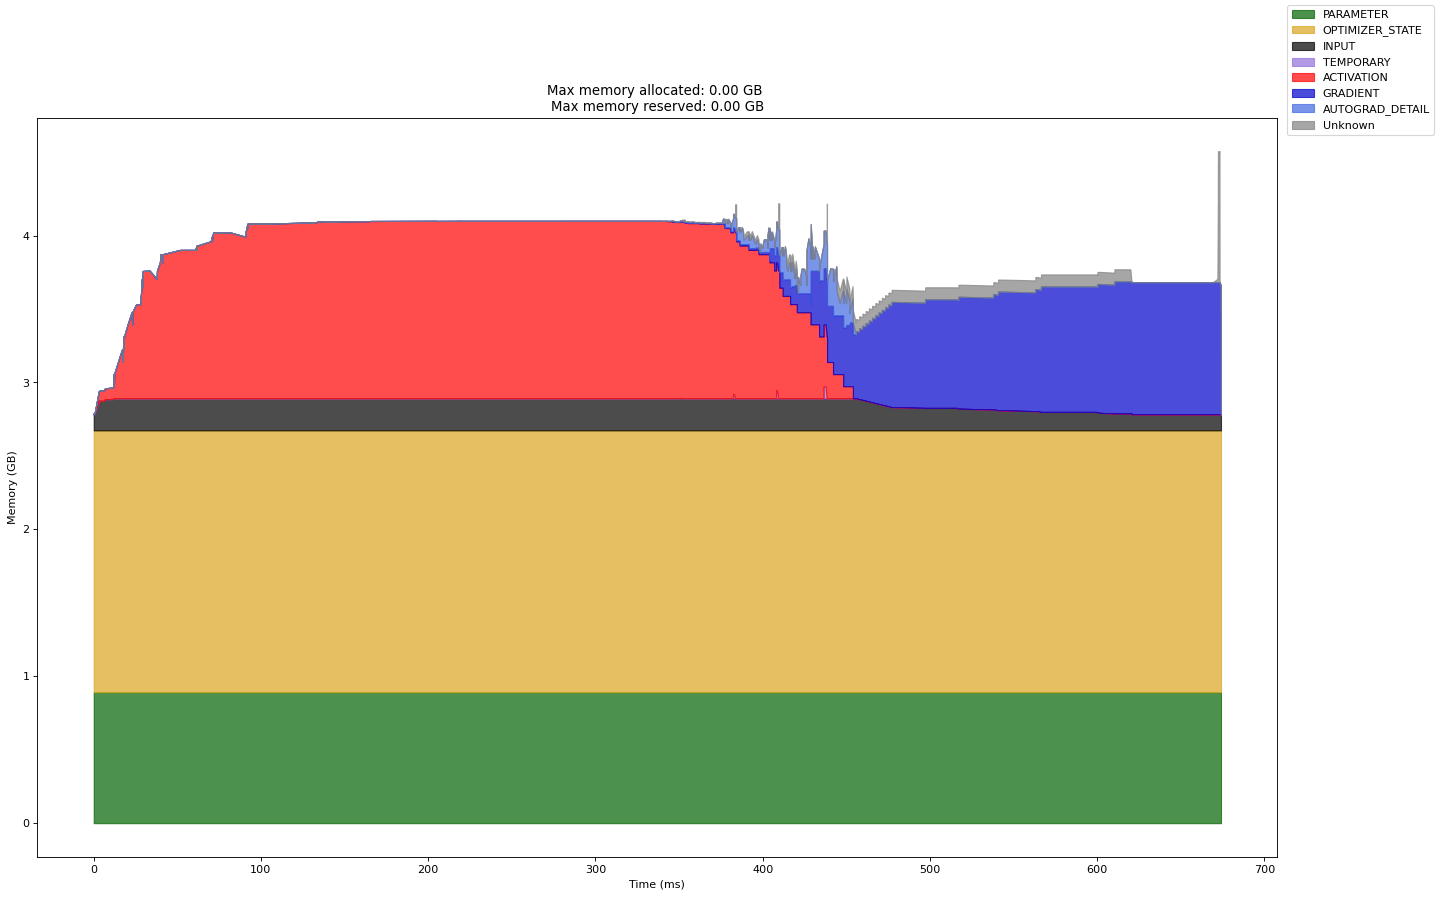

In [12]:
modelname="Linformer"
n_group = 20
encoder = AttOmicsEncoder(
    in_features=feature_numbers, n_group=n_group, group_size_list=[2164, 1459, 754, 50],
    num_heads=1, flatten_output=True, pe=False, permutation=False, permu_inverse=False, 
    mem_efficient = True, isLinformer= True
)

head = FullyConnectedNetwork(
    [FullyConnectedLayer(input_dim=n_group*50, output_dim=n_group*25), 
    FullyConnectedLayer(input_dim=n_group*25, output_dim=n_group*10),]
)

model = AttOmics(encoder=encoder, head=head, num_classes=num_classes)

optimizer=optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True, 
    record_shapes=True,
    with_stack=True,
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=6,
        active=1),
    on_trace_ready=trace_handler
) as p:
    for idx in range(8):
        #print(idx)
        p.step()
        pred = model(inputs)
        loss_function_weight(pred, labels).backward()
        optimizer.step()
        optimizer.zero_grad()

del model
torch.cuda.empty_cache()

(Time_Recorder, Memory_Recorder)= record_time_memory(modelname,Time_Recorder,Memory_Recorder)

Text(0, 0.5, 'Max Memory Allocated (GB)')

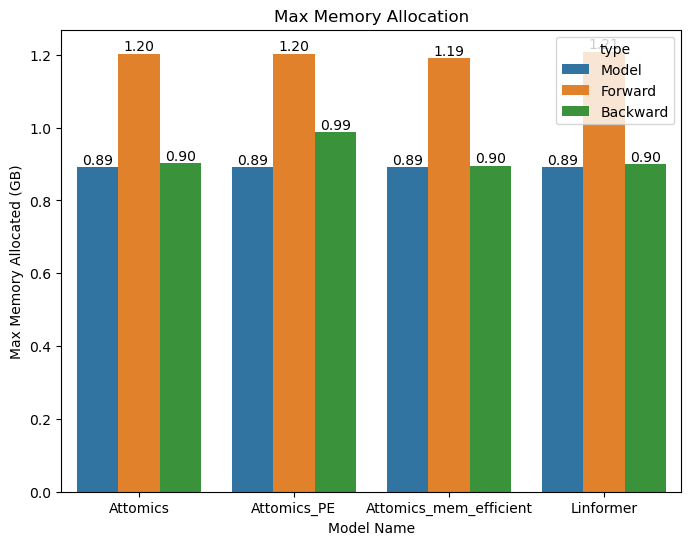

In [13]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='model_name', y='max_memory_allocated', hue='type', data=Memory_Recorder)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.title('Max Memory Allocation')
plt.xlabel('Model Name')
plt.ylabel('Max Memory Allocated (GB)')

Text(0, 0.5, 'Total time (s)')

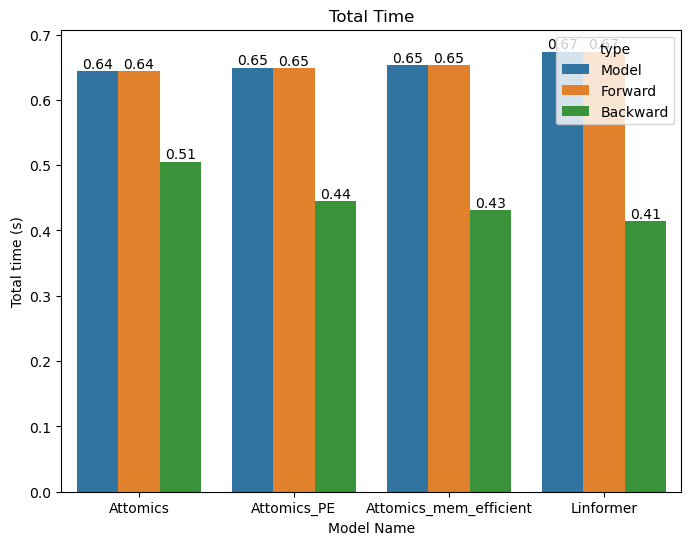

In [14]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='model_name', y='total_time', hue='type', data=Time_Recorder)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.title('Total Time')
plt.xlabel('Model Name')
plt.ylabel('Total time (s)')

### Group test

In [15]:
Memory_Recorder = pd.DataFrame(columns=['model_name', 'type', 'max_memory_allocated'])
Time_Recorder = pd.DataFrame(columns=['model_name', 'type', 'total_time'])

STAGE:2024-04-11 13:25:26 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:25:26 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:25:26 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-11 13:25:31 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:25:32 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:25:32 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-11 13:25:39 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:25:40 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:25:40 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-11 13:25:49 1496798:149679

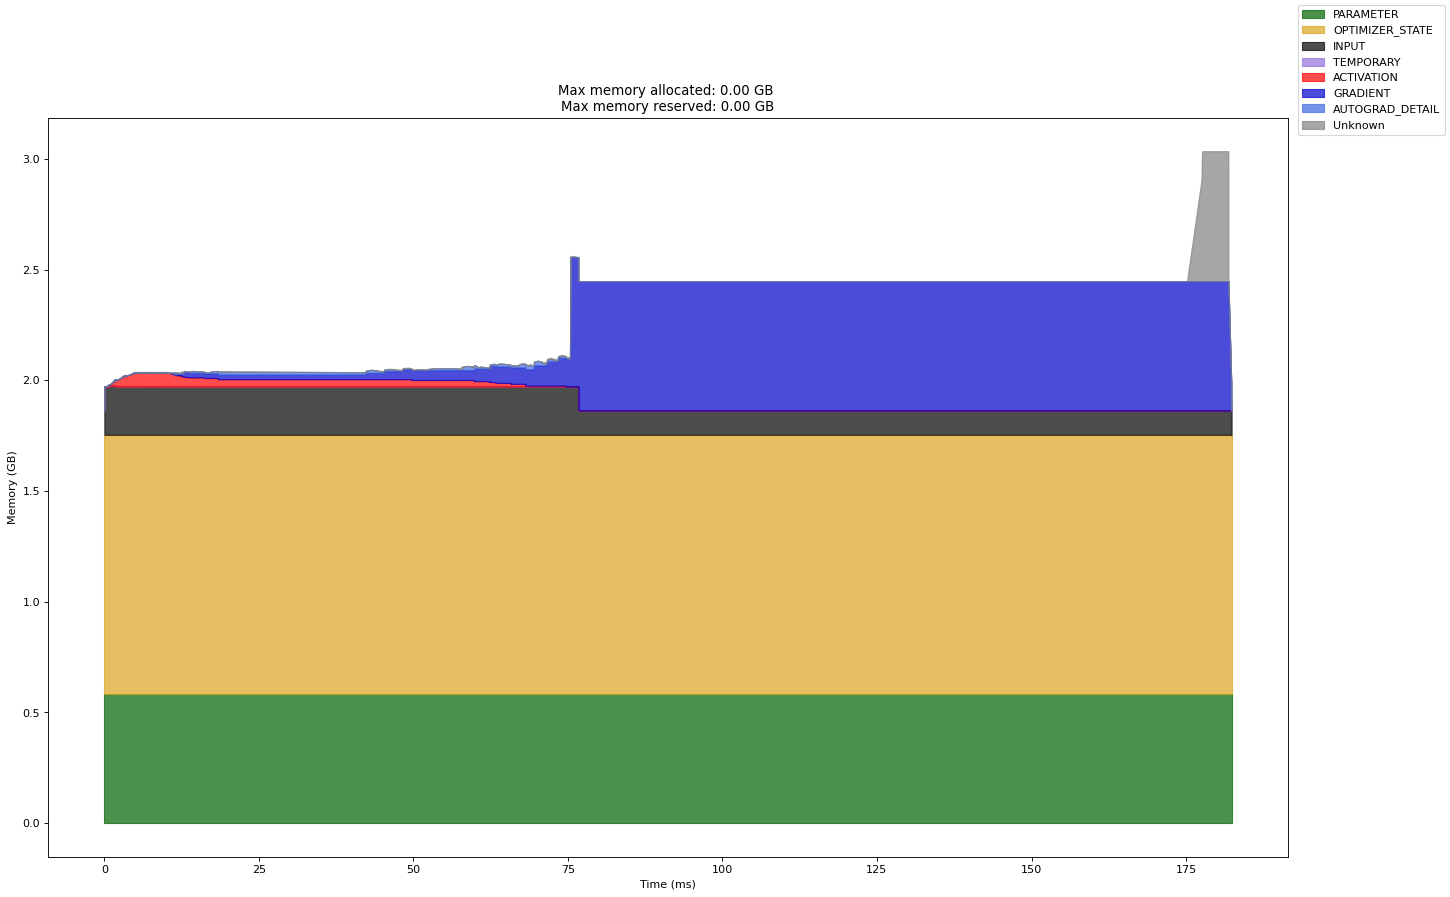

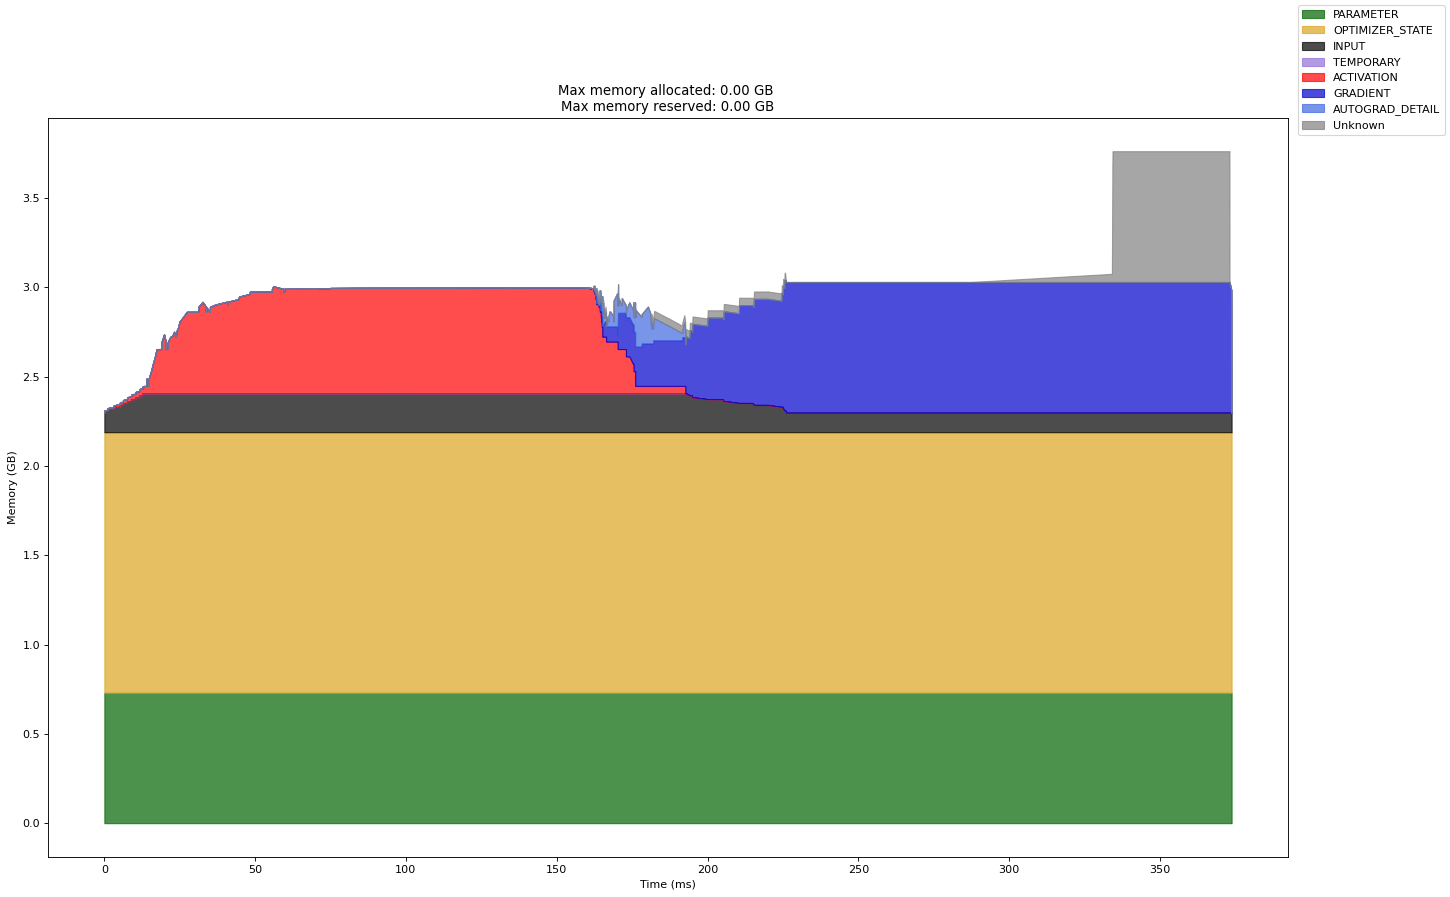

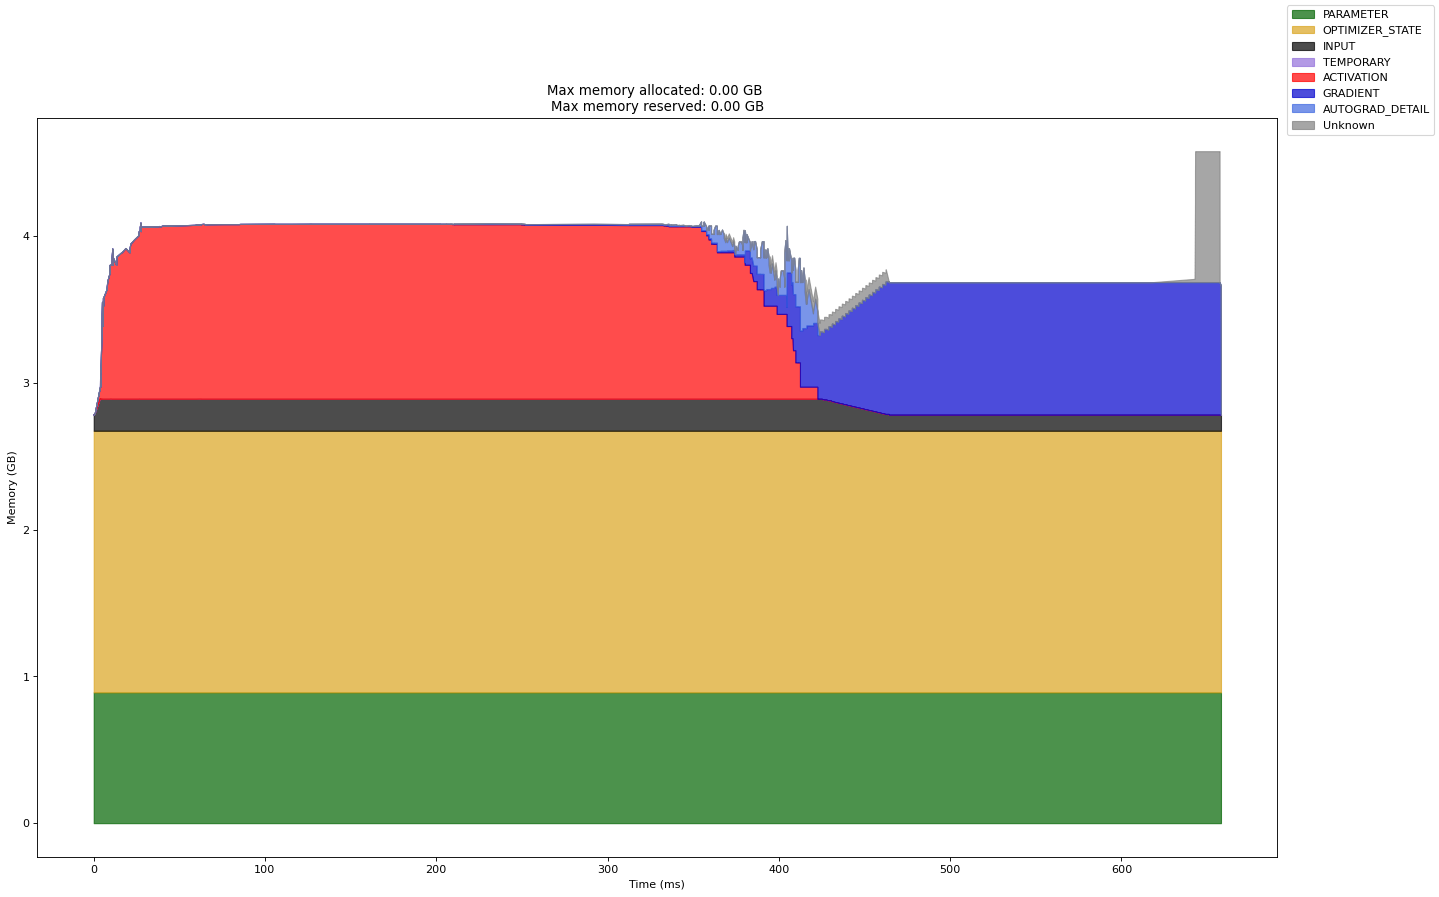

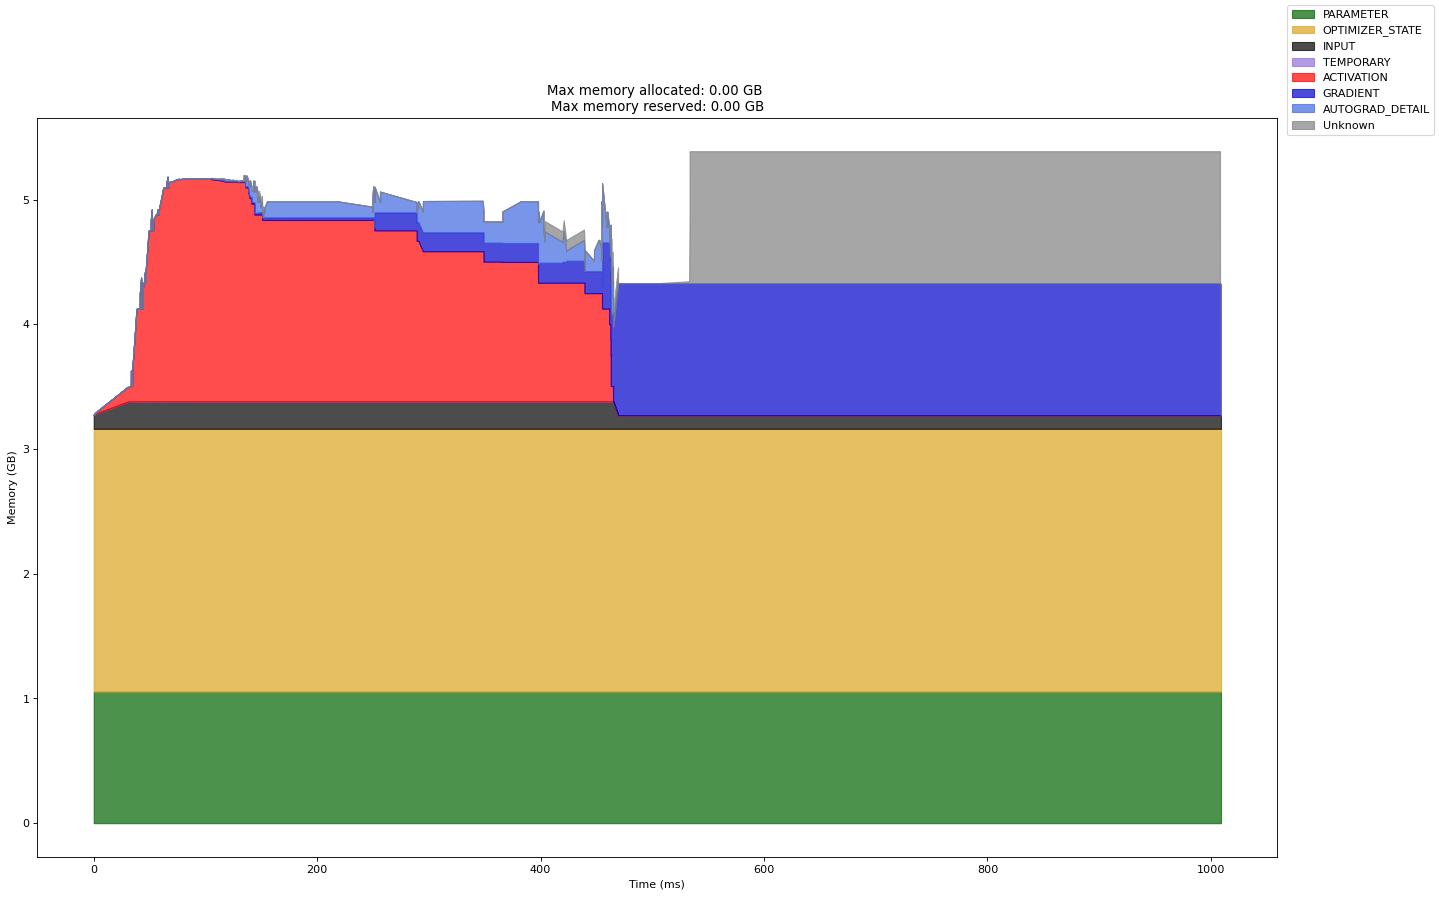

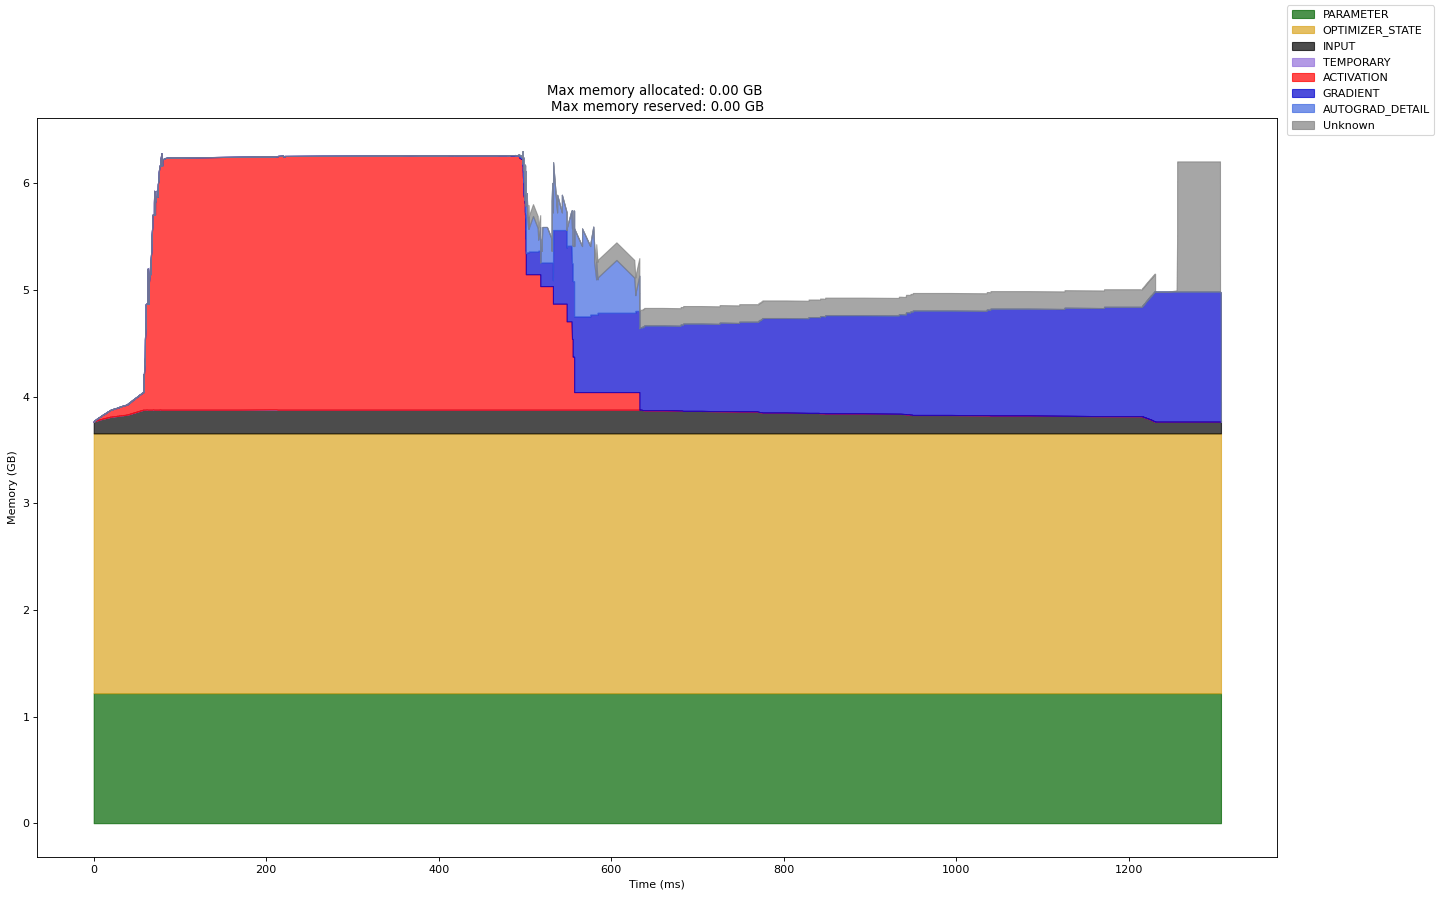

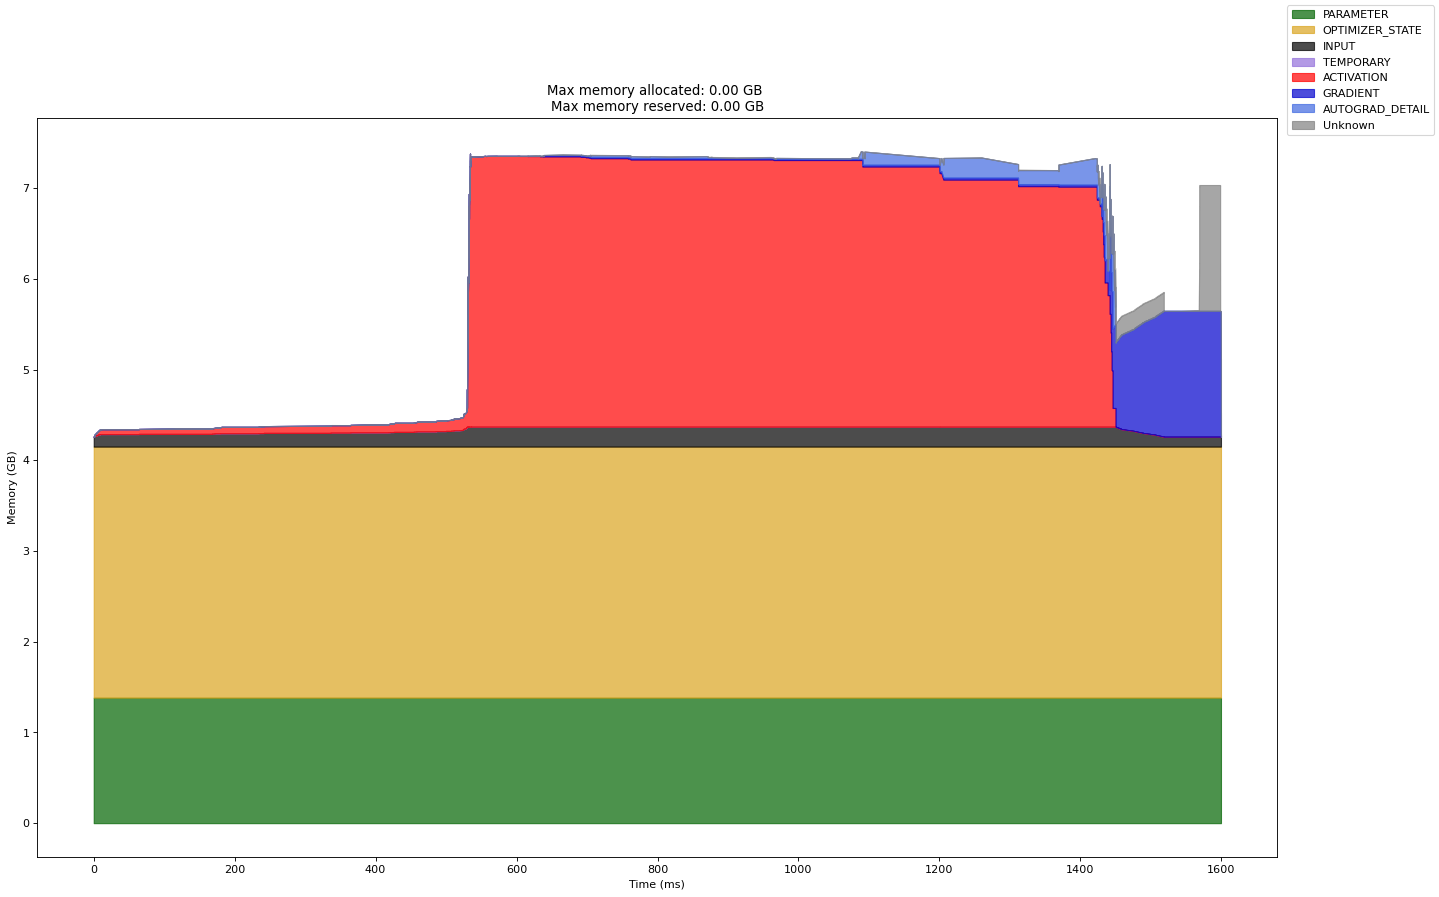

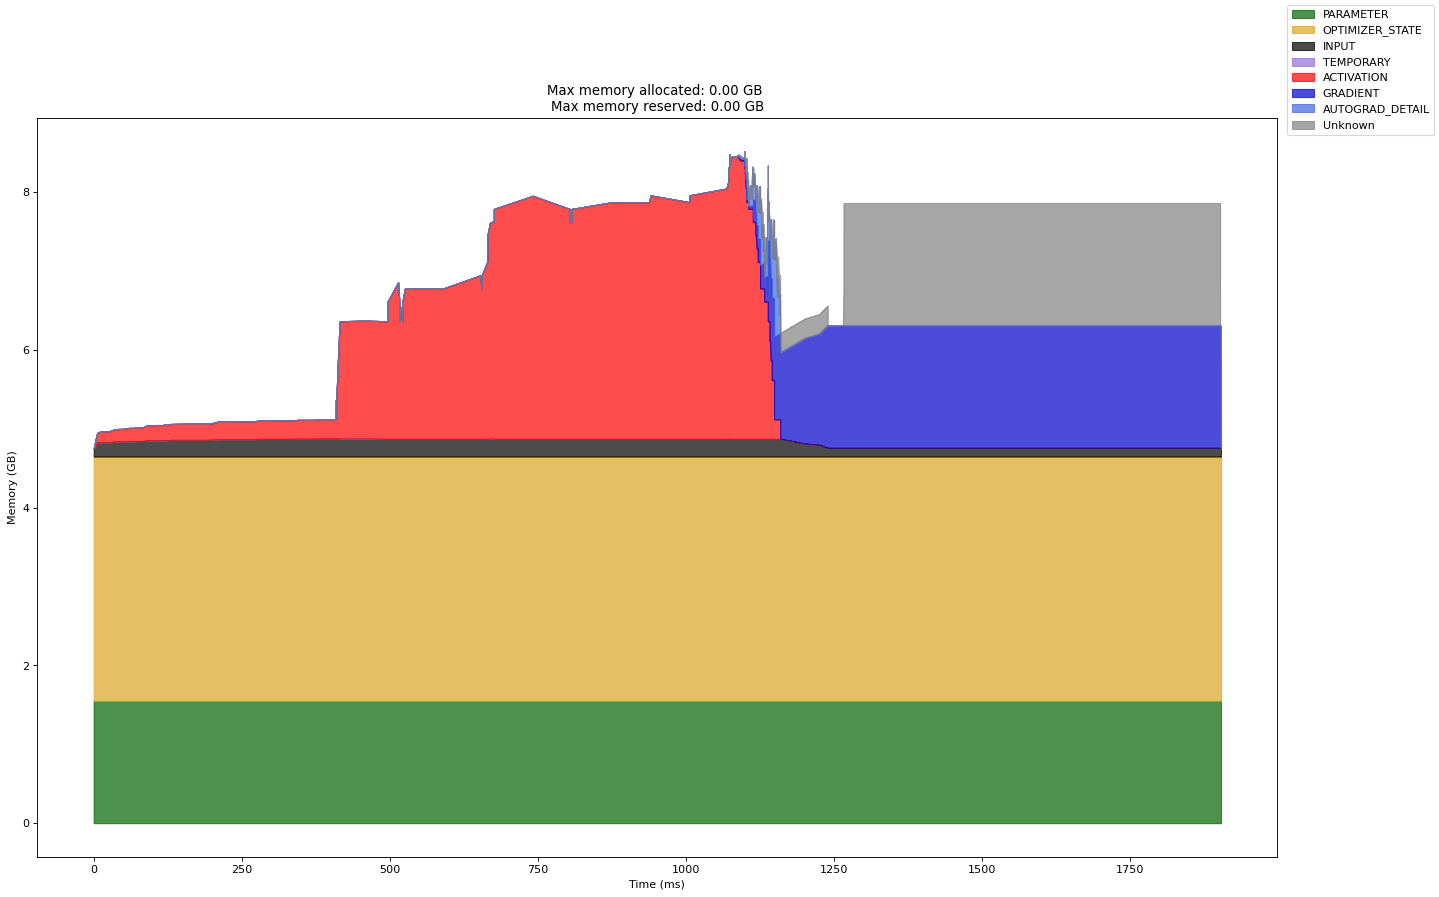

In [16]:
#Create new model
input_dim = feature_numbers
n_groups = [1,10,20,30,40,50,60]

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

for n_group in n_groups:
    
    modelname=f"Attomics_{n_group}"
    #1 Groups = 50 inputs
    encoder = AttOmicsEncoder(
        in_features=input_dim, n_group=n_group, group_size_list=[2164, 1459, 754, 50],
        num_heads=1, flatten_output=True, pe=False, permutation=False, permu_inverse=False, mem_efficient = False,
    )

    head = FullyConnectedNetwork(
        [FullyConnectedLayer(input_dim=n_group*50, output_dim=n_group*25), 
        FullyConnectedLayer(input_dim=n_group*25, output_dim=n_group*10),]
    )

    model = AttOmics(encoder=encoder, head=head, num_classes=num_classes)

    optimizer=optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)

    def trace_handler(p):
        p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
        p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, 
        record_shapes=True,
        with_stack=True,
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=6,
            active=1),
        on_trace_ready=trace_handler
    ) as p:
        for idx in range(8):
            p.step()
            pred = model(inputs)
            loss_function_weight(pred, labels).backward()
            optimizer.step()
            optimizer.zero_grad()

    del model
    torch.cuda.empty_cache()
    
    record_time_memory(modelname,Time_Recorder,Memory_Recorder)

Text(0, 0.5, 'Max Memory Allocated (GB)')

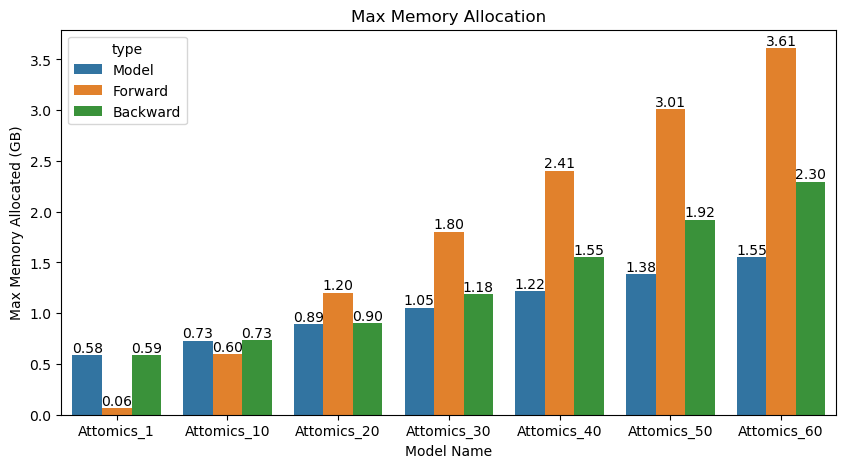

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='model_name', y='max_memory_allocated', hue='type', data=Memory_Recorder)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.title('Max Memory Allocation')
plt.xlabel('Model Name')
plt.ylabel('Max Memory Allocated (GB)')

Text(0, 0.5, 'Total time (s)')

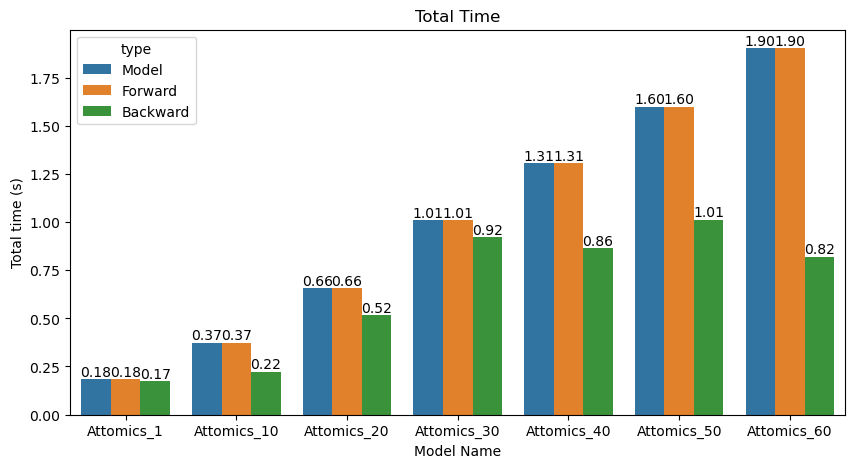

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='model_name', y='total_time', hue='type', data=Time_Recorder)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.title('Total Time')
plt.xlabel('Model Name')
plt.ylabel('Total time (s)')

### Linformer Test

In [19]:
Memory_Recorder = pd.DataFrame(columns=['model_name', 'type', 'max_memory_allocated'])
Time_Recorder = pd.DataFrame(columns=['model_name', 'type', 'total_time'])

STAGE:2024-04-11 13:26:54 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:26:54 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:26:54 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-11 13:26:59 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:27:00 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:27:00 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-11 13:27:07 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:27:08 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:27:08 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-11 13:27:18 1496798:149679

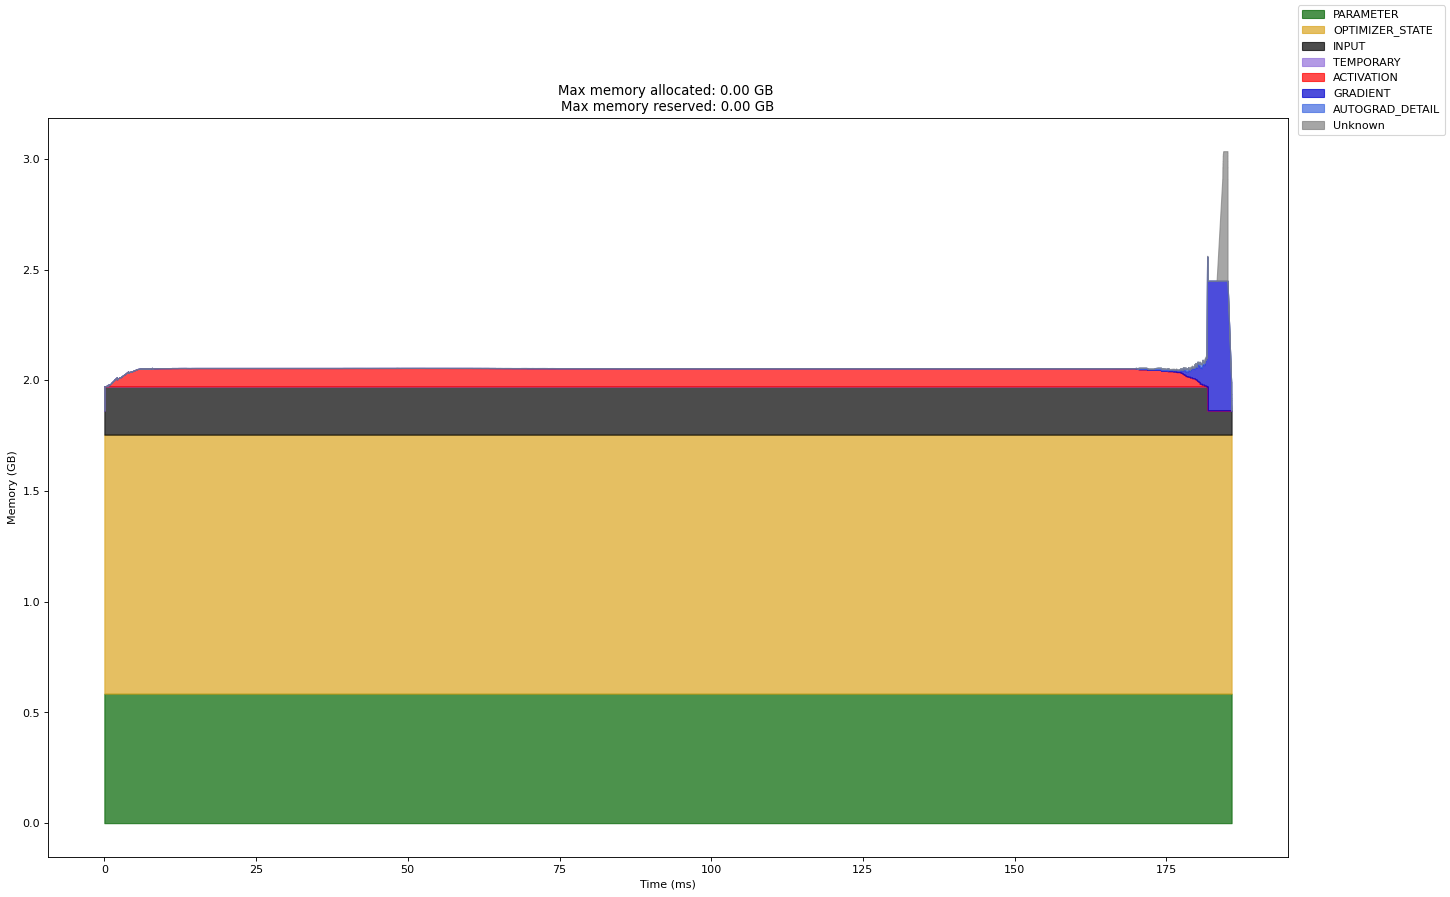

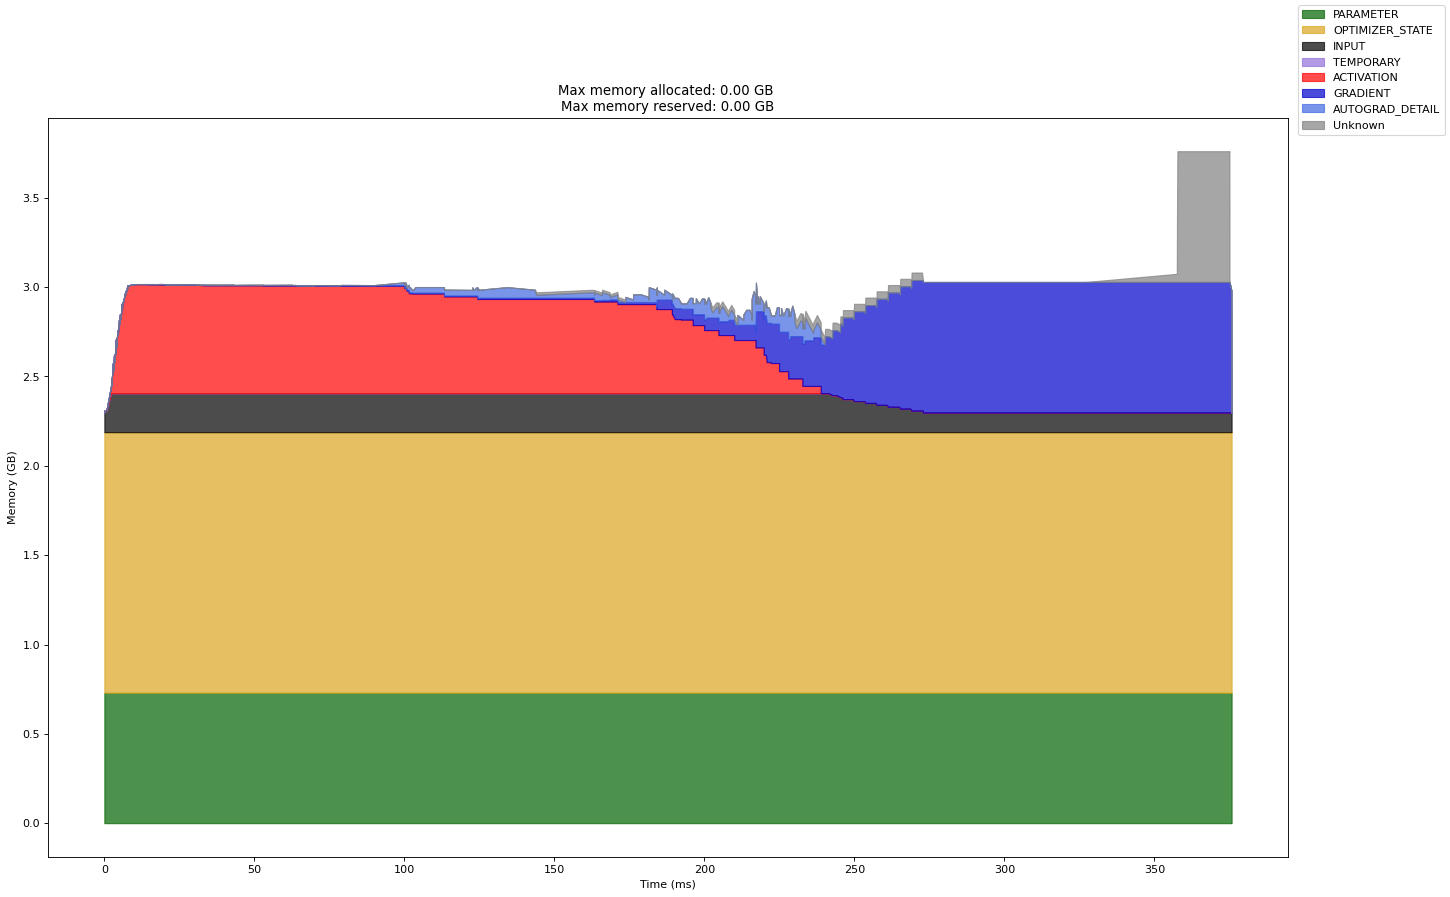

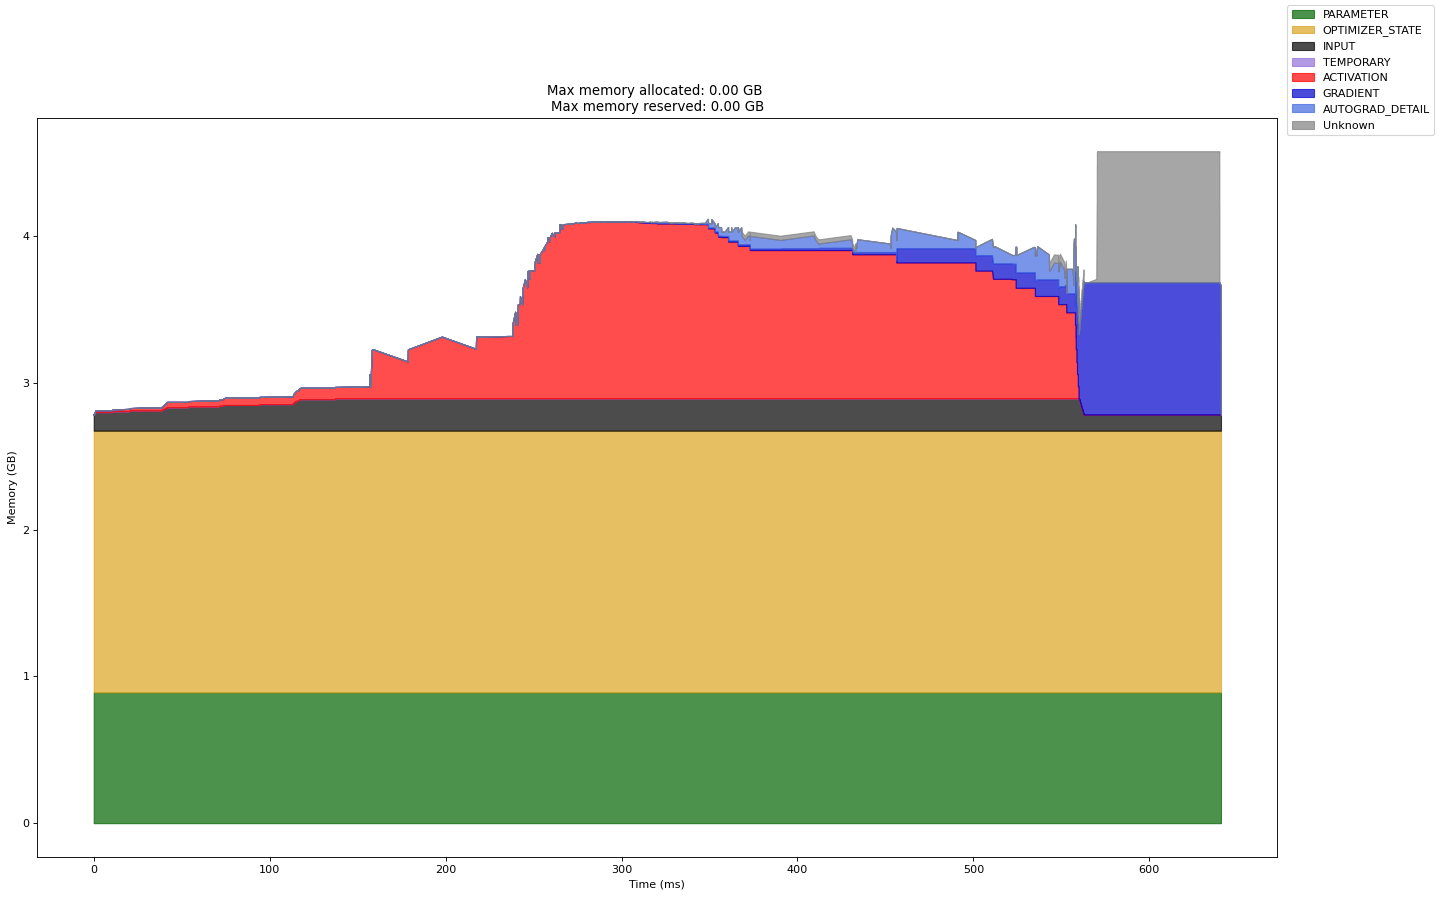

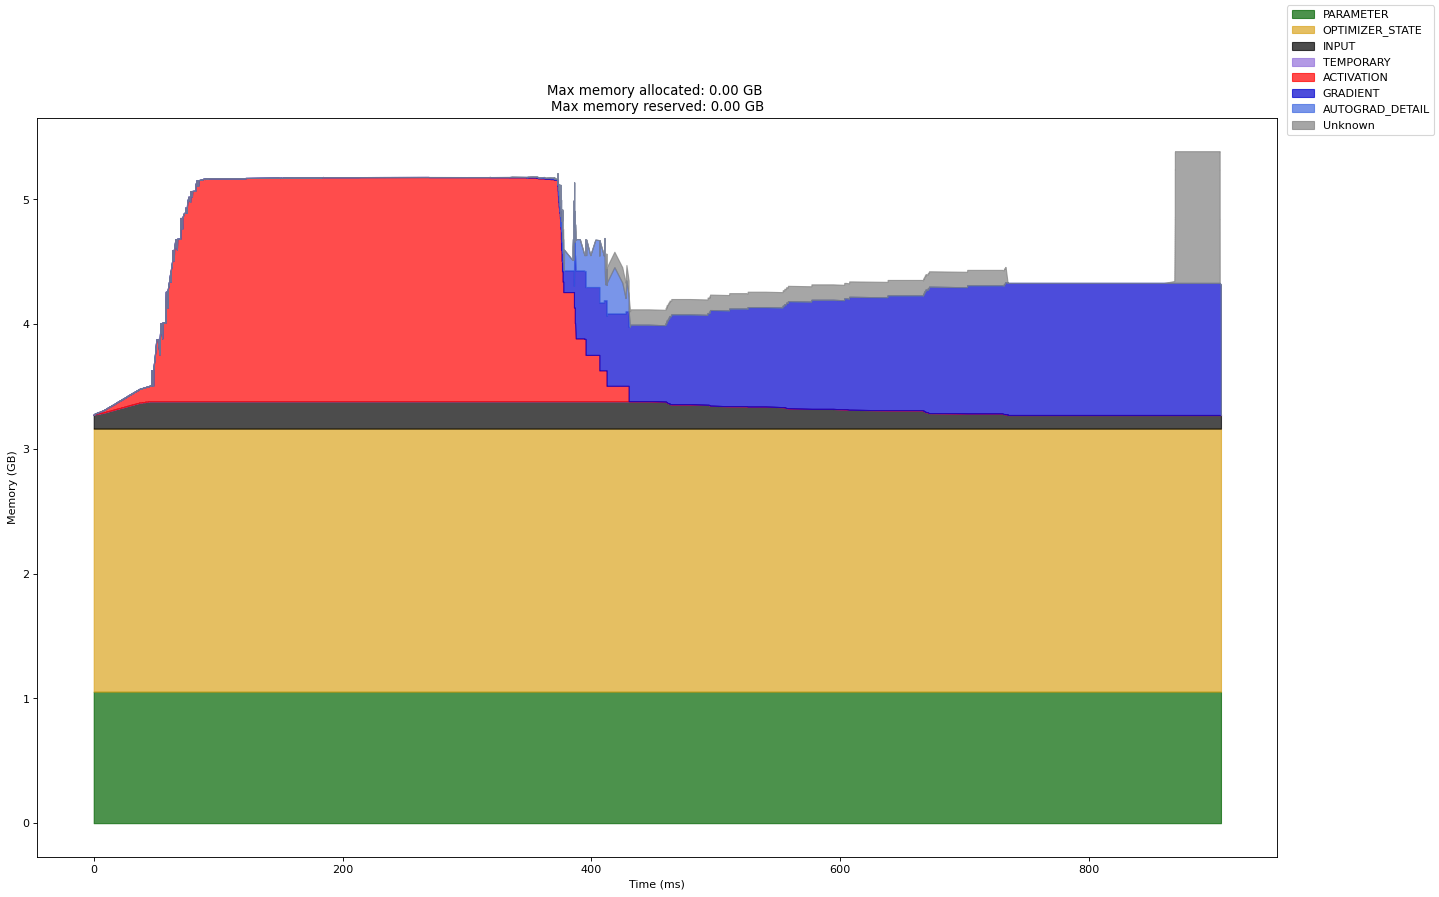

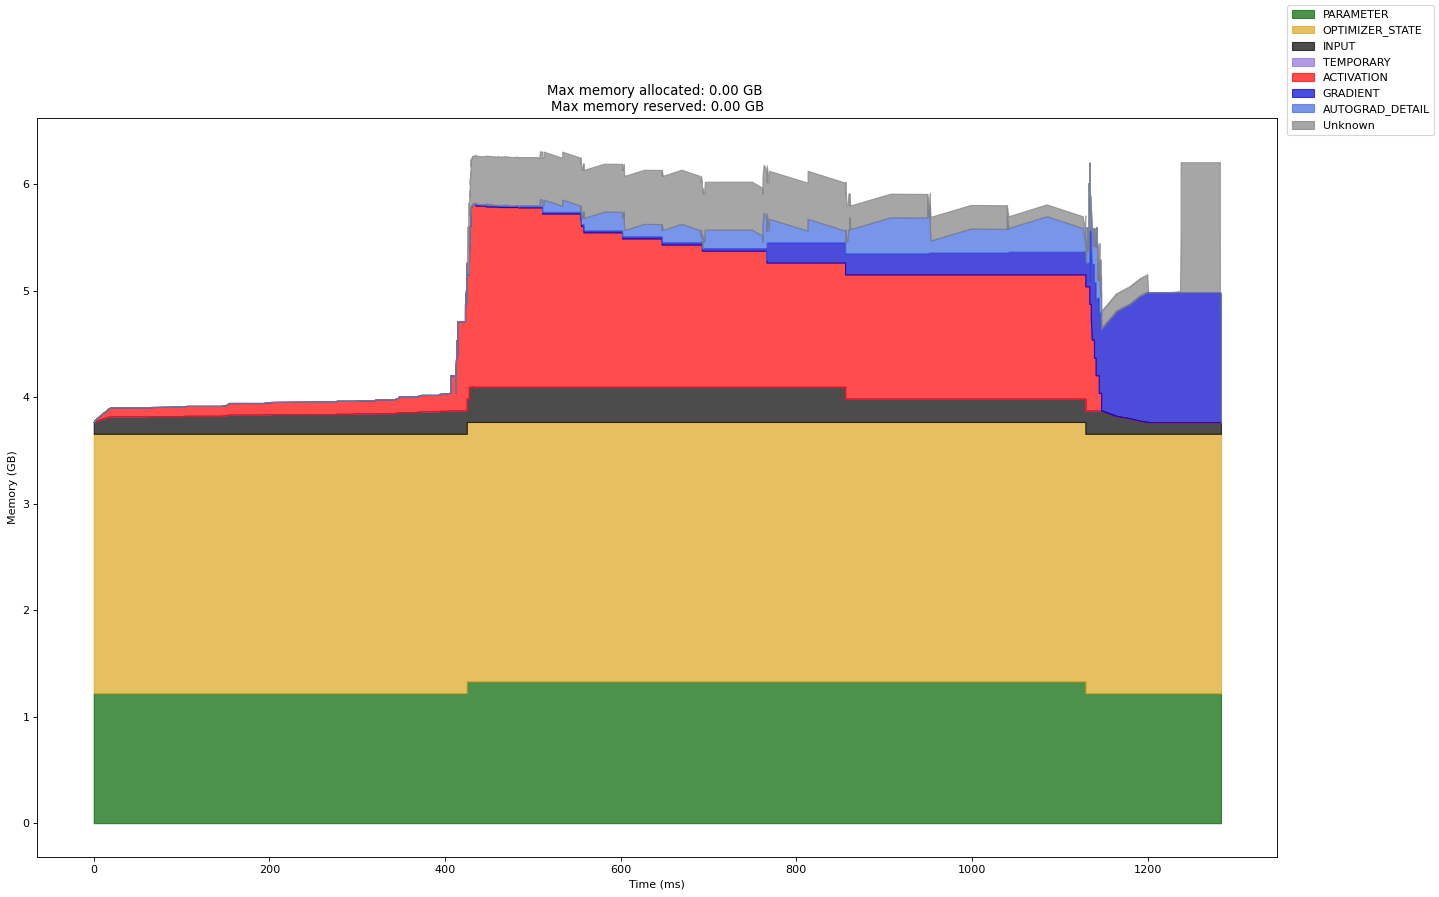

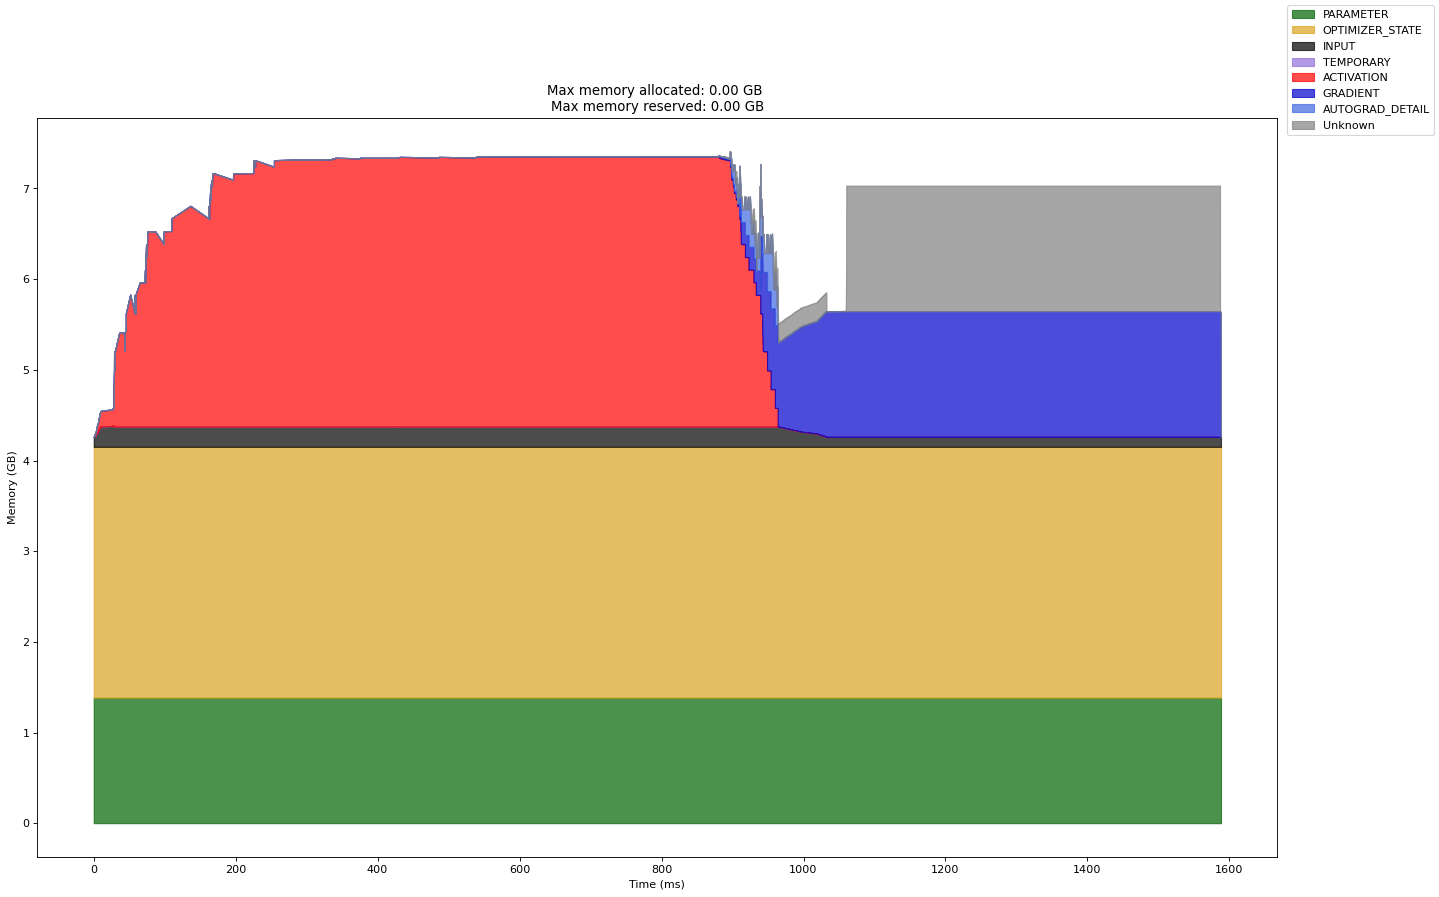

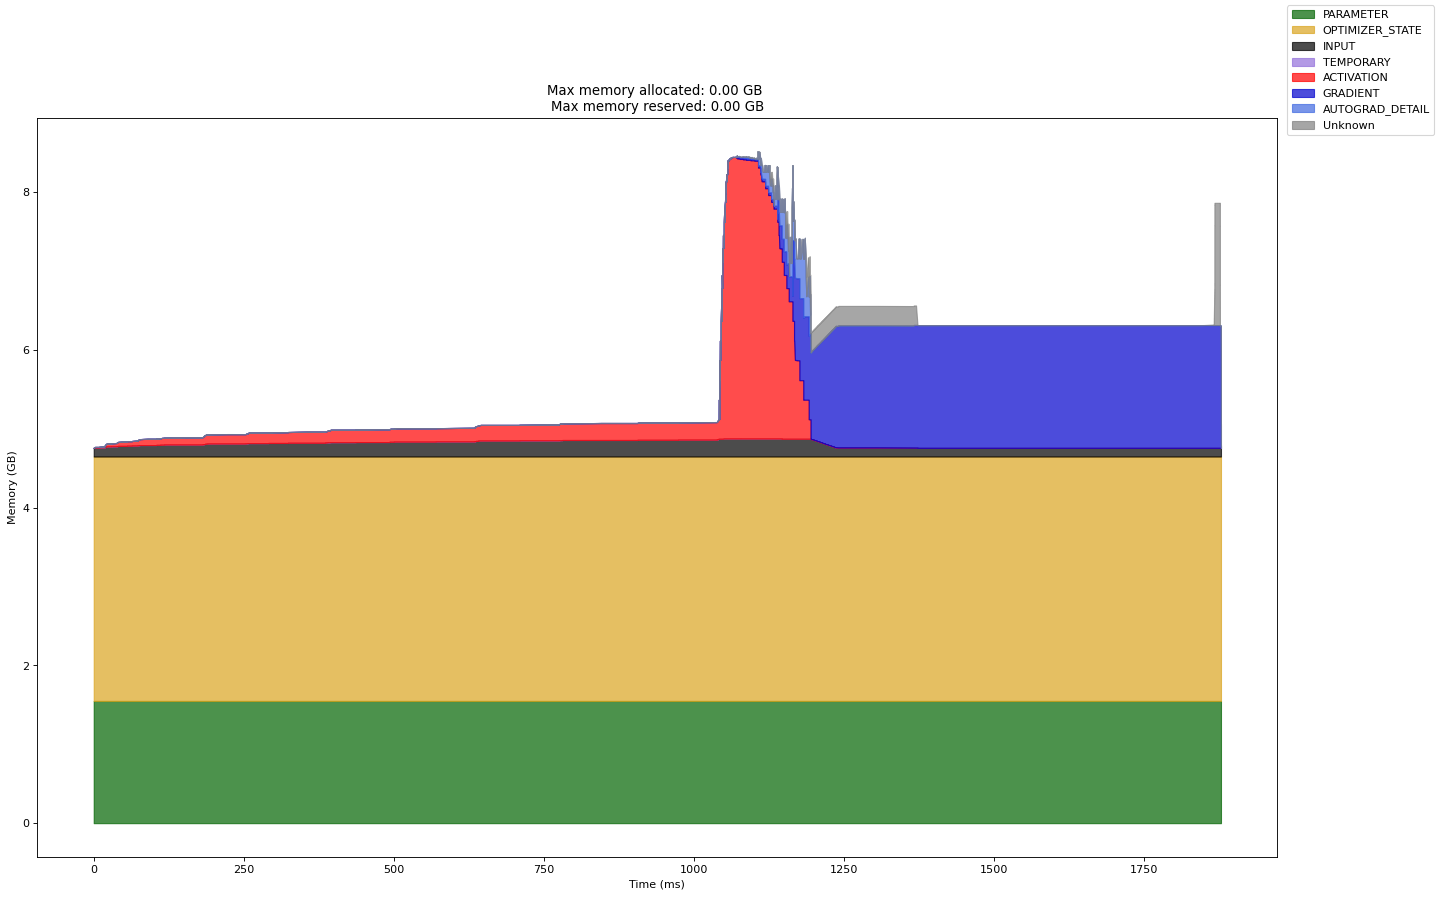

In [20]:
#Create new model
input_dim = feature_numbers
n_groups = [1,10,20,30,40,50,60]

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

for n_group in n_groups:
    
    modelname=f"Linformer_{n_group}"
    #1 Groups = 50 inputs
    encoder = AttOmicsEncoder(
        in_features=input_dim, n_group=n_group, group_size_list=[2164, 1459, 754, 50],
        num_heads=1, flatten_output=True, pe=False, permutation=False, permu_inverse=False, 
        mem_efficient = False, isLinformer= True
    )

    head = FullyConnectedNetwork(
        [FullyConnectedLayer(input_dim=n_group*50, output_dim=n_group*25), 
        FullyConnectedLayer(input_dim=n_group*25, output_dim=n_group*10),]
    )

    model = AttOmics(encoder=encoder, head=head, num_classes=num_classes)

    optimizer=optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)

    def trace_handler(p):
        p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
        p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, 
        record_shapes=True,
        with_stack=True,
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=6,
            active=1),
        on_trace_ready=trace_handler
    ) as p:
        for idx in range(8):
            p.step()
            pred = model(inputs)
            loss_function_weight(pred, labels).backward()
            optimizer.step()
            optimizer.zero_grad()

    del model
    torch.cuda.empty_cache()
    
    record_time_memory(modelname,Time_Recorder,Memory_Recorder)

Text(0, 0.5, 'Max Memory Allocated (GB)')

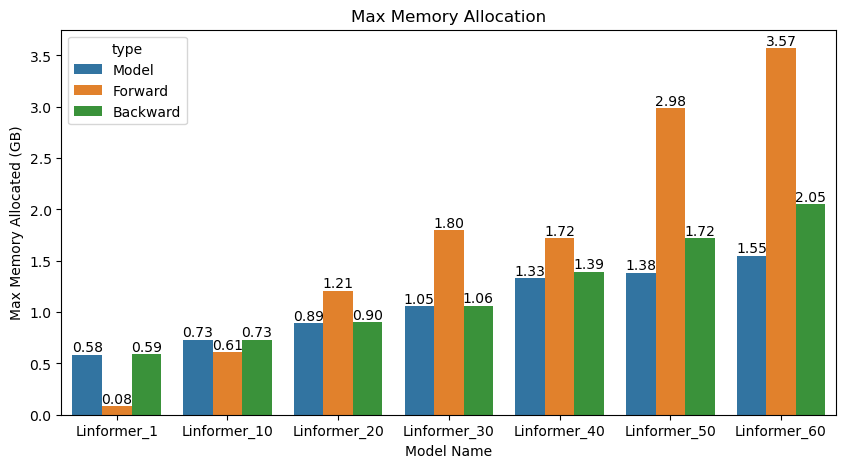

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='model_name', y='max_memory_allocated', hue='type', data=Memory_Recorder)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.title('Max Memory Allocation')
plt.xlabel('Model Name')
plt.ylabel('Max Memory Allocated (GB)')

Text(0, 0.5, 'Total time (s)')

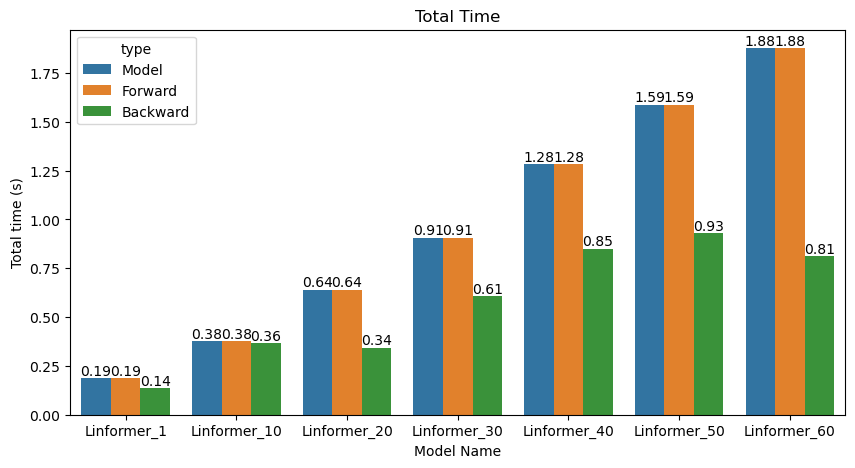

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='model_name', y='total_time', hue='type', data=Time_Recorder)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.title('Total Time')
plt.xlabel('Model Name')
plt.ylabel('Total time (s)')

### Large Group number test

In [23]:
#Create new model
input_dim = feature_numbers
n_groups = [100,200,300,400,500]

def trace_handler(p):
    p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
    p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

for n_group in n_groups:
    
    modelname=f"Linformer_{n_group}"
    #1 Groups = 50 inputs
    encoder = AttOmicsEncoder(
        in_features=input_dim, n_group=n_group, group_size_list=[2164, 1459, 754, 50],
        num_heads=1, flatten_output=True, pe=False, permutation=False, permu_inverse=False, 
        mem_efficient = False, isLinformer= True
    )

    head = FullyConnectedNetwork(
        [FullyConnectedLayer(input_dim=n_group*50, output_dim=n_group*25), 
        FullyConnectedLayer(input_dim=n_group*25, output_dim=n_group*10),]
    )

    model = AttOmics(encoder=encoder, head=head, num_classes=num_classes)

    optimizer=optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)

    def trace_handler(p):
        p.export_memory_timeline(f"memory_recorder/{modelname}.html", device="cuda:1")
        p.export_memory_timeline(f"memory_recorder/{modelname}.json", device="cuda:1")

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, 
        record_shapes=True,
        with_stack=True,
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=6,
            active=1),
        on_trace_ready=trace_handler
    ) as p:
        for idx in range(8):
            p.step()
            pred = model(inputs)
            loss_function_weight(pred, labels).backward()
            optimizer.step()
            optimizer.zero_grad()

    del model
    torch.cuda.empty_cache()
    
    record_time_memory(modelname,Time_Recorder,Memory_Recorder)

STAGE:2024-04-11 13:28:29 1496798:1496798 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-11 13:28:29 1496798:1496798 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-11 13:28:29 1496798:1496798 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


OutOfMemoryError: CUDA out of memory. Tried to allocate 420.00 MiB. GPU 1 has a total capacity of 11.93 GiB of which 214.38 MiB is free. Process 1359823 has 11.71 GiB memory in use. Of the allocated memory 11.10 GiB is allocated by PyTorch, and 90.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)